In [1]:
import sys, os
#path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir, 'dir1')))
#print(os.getcwd())
parent_path = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
sys.path.append(parent_path)
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii")))

import json
import yaml
from underpinnings.OccupancyMap2 import OccupancyMap2, LidarMeasurement, ExactLidarMeasurement
import numpy as np
from gyrii.underpinnings.BayesianArray import BayesianArray

import json
import yaml

    
def dict_array_upend(mydict,key,elem):
    if key not in mydict:
        mydict[key]=[]
    mydict[key.append(elem)]

def load_sensor_log_file(fname):
    response=[]
    first_timestamp=0
    f=open(fname,'r')
    for line in f.readlines():        
        dat=json.loads(line)
        timestamp=dat["timestamp"]-first_timestamp
        response.append(dat)
        if first_timestamp==0:                        
            first_timestamp=timestamp
    return response,first_timestamp
        
#sensor_log,first_timestamp=load_sensor_log_file("../logs/sensor_log_20210425-083922.txt")
sensor_log,first_timestamp=load_sensor_log_file("../logs/sensor_log_20210425-212438.txt")


In [2]:
from Gyrus import Gyrus
from TimeSeries import TimeSeries
import numpy as np
from gyrii.underpinnings.BayesianArray import BayesianArray

class PosePlotter(Gyrus):
    def __init__(self):
        self.x_dataseries=TimeSeries(title="Pose X",ylabel="X Position (m)")
        self.x_unc_dataseries=TimeSeries(title="Pose X Unc",ylabel="X Position Uncertainty (m)")
        self.y_dataseries=TimeSeries(title="Pose Y",ylabel="X Position (m)")
        self.y_unc_dataseries=TimeSeries(title="Pose Y Unc",ylabel="X Position Uncertainty (m)")
        self.theta_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle (radians)")
        self.theta_unc_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle Uncertainty (radians)")
        self.lx_dataseries=TimeSeries(title="Pose X",ylabel="X Position Lidar (m)")
        self.lx_unc_dataseries=TimeSeries(title="Pose X Unc",ylabel="X Lidar Position Uncertainty (m)")
        self.ly_dataseries=TimeSeries(title="Pose Y",ylabel="X Position Lidar (m)")
        self.ly_unc_dataseries=TimeSeries(title="Pose Y Unc",ylabel="X Lidar Position Uncertainty (m)")
        self.ltheta_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle (radians)")
        self.ltheta_unc_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle Uncertainty (radians)")
        self.ctheta_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle (radians)")
        self.ctheta_unc_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle Uncertainty (radians)")   
        self.motor_durations=TimeSeries(title="Motor Duration")
        self.bfield_times=[]
        self.bfields=[]
        
        
        
    def read_message(self,message):
        if "latest_pose" in message and "timestamp" in message:
            if message["pose_notes"]!="pose_is_stable":
                return
            self.x_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][0])
            self.x_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][0][0]))
            self.y_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][1])
            self.y_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][1][1]))
            self.theta_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][2])
            self.theta_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][2][2]))
        if "notes" in message and message["notes"]=="lidar":
            self.lx_dataseries.append(message["timestamp"],message["pose_measurement"]["vals"][0])
            self.lx_unc_dataseries.append(message["timestamp"],np.sqrt(message["pose_measurement"]["covariance"][0][0]))
            self.ly_dataseries.append(message["timestamp"],message["pose_measurement"]["vals"][1])
            self.ly_unc_dataseries.append(message["timestamp"],np.sqrt(message["pose_measurement"]["covariance"][1][1]))
            self.ltheta_dataseries.append(message["timestamp"],message["pose_measurement"]["vals"][2])
            self.ltheta_unc_dataseries.append(message["timestamp"],np.sqrt(message["pose_measurement"]["covariance"][2][2]))
        if "notes" in message and message["notes"]=="compass":
            self.ctheta_dataseries.append(message["timestamp"],message["pose_measurement"]["vals"][2])
            self.ctheta_unc_dataseries.append(message["timestamp"],np.sqrt(message["pose_measurement"]["covariance"][2][2]))
        if "magnetometer/b_field" in message:
            self.bfield_times.append(message["timestamp"])
            self.bfields.append(np.array(message["magnetometer/b_field"])    )  
        if "drive/motors_active" in message:
            if message["drive/motors_active"][3]< 100:
                self.motor_durations.append(message["timestamp"],message["drive/motors_active"][3])

        return []


plotters={}
plotters["pose"]=PosePlotter()

gyrii=[]
#gyrii.append(MotionEstimationGyrus(None))
#mcgyrus=MotionCalibGyrus()
#gyrii.append(mcgyrus)

for key in plotters:
    gyrii.append(plotters[key])

start_timestamp=sensor_log[0]["timestamp"]
inspect_messagename="none"

remove_messages=["po"]

for i in range(len(sensor_log)):    
    for m in remove_messages:
        if m in sensor_log[i]:            
            #print("removing {}".format(sensor_log[i]))            
            sensor_log[i].pop(m,None)
            #print("removing {}".format(sensor_log[i]))                      
    start_message=sensor_log[i]
    start_message["timestamp"]-=start_timestamp #rescale time to zero at start
    waiting_messages=[ start_message ]    
    while len(waiting_messages)!=0:
        on_message=waiting_messages.pop()
        if inspect_messagename in on_message:
            print(on_message)
        for g in gyrii:
            resp=g.read_message(on_message)
            if resp is not None:
                waiting_messages.extend(resp)

C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


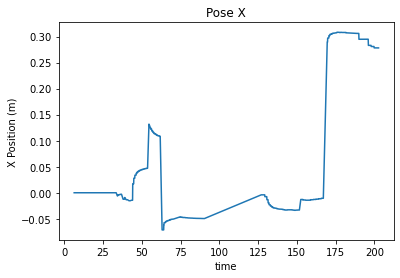

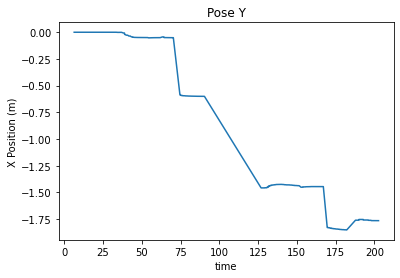

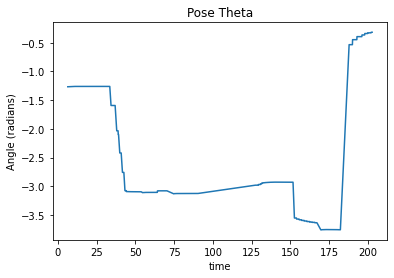

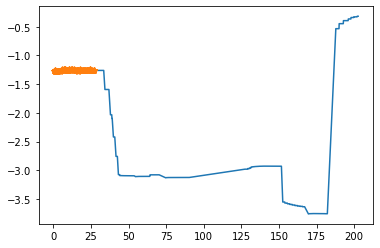

C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


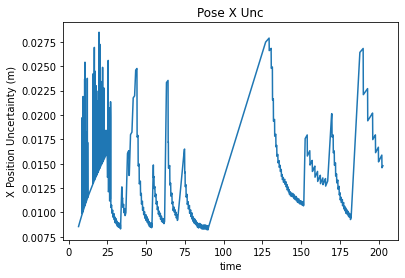

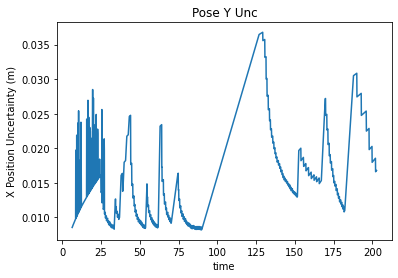

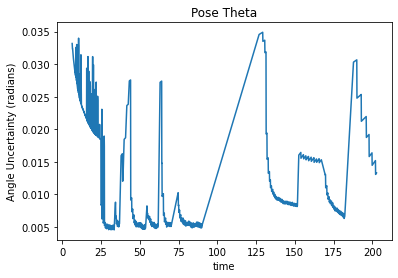

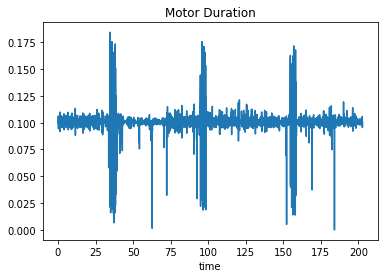

In [3]:
import matplotlib.pyplot as plt
plotters["pose"].x_dataseries.plot()
plotters["pose"].y_dataseries.plot()
plotters["pose"].theta_dataseries.plot()
plt.figure()
#plt.xlim(10,14)
plt.plot(plotters["pose"].theta_dataseries.times,plotters["pose"].theta_dataseries.data)
plt.plot(plotters["pose"].ctheta_dataseries.times,plotters["pose"].ctheta_dataseries.data,'*')
plt.show()
plotters["pose"].x_unc_dataseries.plot()
plotters["pose"].y_unc_dataseries.plot()
plotters["pose"].theta_unc_dataseries.plot()

plotters["pose"].motor_durations.plot()

In [4]:
#last_lidar_scan=sensor_log[-5]
#last_lidar_scan=sensor_log[-399]
#test_lidar_scan=last_lidar_scan["lidar/lidar_scan"]

#last_pose_log=sensor_log[-400]
#latest_pose=BayesianArray.from_object(last_pose_log["latest_pose"])
#print("latest pose {}".format(latest_pose.pretty_str()))
#print(sensor_log[-400])


latest pose  0.291+/-0.022 -1.831+/-0.023 -2.629+/-0.026
{'timestamp': 182.89640069007874, 'latest_pose': {'vals': [0.2908370389290048, -1.8306134800682239, -2.6292997116443795], 'covariance': [[0.0004844106164773131, 8.222973175334977e-06, 5.5565406091023355e-06], [8.222973175334982e-06, 0.0005152457738376821, 3.1071243783591623e-07], [5.556540609102339e-06, 3.1071243783591676e-07, 0.0006563932456250278]]}, 'latest_pose_vel': {'vals': [-0.00593330705930705, 0.042225803620637034, 1.7609665044710925], 'covariance': [[0.006058479569694008, 4.805693547261225e-57, 4.089458812744078e-55], [4.8056935472612226e-57, 0.006058479569694008, -7.80113049030083e-56], [4.089458812744074e-55, -7.801130490300821e-56, 0.009209887740356205]]}, 'pose_notes': 'pose_unstable'}


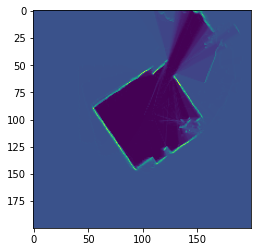

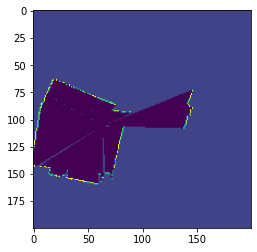

In [5]:
import matplotlib.pyplot as plt


mymap=OccupancyMap2.load_from_file("../local_map.npy")
plt.figure()
plt.imshow(mymap.gridmap_logodds[100:300,100:300])
plt.show()

lidarmap=OccupancyMap2(mymap.resolution,mymap.npoints_x,mymap.npoints_x)

m_test=ExactLidarMeasurement([ x[2]/1000 for x in test_lidar_scan], [ np.radians(x[1]) for x in test_lidar_scan] )
lidarmap.apply_exact_lidar_measurement3(latest_pose.vals,m_test,weight=10)    
plt.figure()
plt.imshow(lidarmap.gridmap_logodds[100:300,100:300])
plt.show()

In [6]:


posemap,xs,ys,ts,cvabs=mymap.get_lidar_pose_map3_withtheta(latest_pose.vals,m_test,theta_points=10,theta_res=np.radians(1))


newpose,score=mymap.pose_map_to_pose_prediction3_with_theta_faster(posemap,xs,ys,ts,cvabs,center=latest_pose,spread_size_x=10,spread_size_y=10)
print("score is {}".format(score))
print("old pose is {}".format(latest_pose.pretty_str()))
print("new pose is {}".format(newpose.pretty_str()))

center=latest_pose
a=ts.searchsorted(center.vals[2])
b=xs.searchsorted(center.vals[0])
c=ys.searchsorted(center.vals[1])
best_point=(a,b,c)
posemap=posemap[a-10:a+10,b-10:b+10,c-10:c+10]
cvabs=cvabs[a-10:a+10,b-10:b+10,c-10:c+10]

logprobmap=(posemap-cvabs)/np.sqrt(cvabs+1)
probmap=np.exp(logprobmap-np.max(logprobmap))


if True:    
    for i in range(posemap.shape[0]): 
        s=0
        f=300
        #maxval=np.max(posemap[i,125:175,125:175])
        #maxval=np.max(posemap[i,s:f,s:f])        
        #logprobmap=(posemap[i,:,:]-cvabs[i,:,:])/np.sqrt(cvabs[i,:,:]+1)
        #probmap=np.exp(logprobmap-np.max(logprobmap))
        toshow=probmap[i,:,:]
        if True:
            plt.figure()
            #plt.imshow(posemap[i,:,:])
            #plt.imshow(posemap[i,125:175,125:175])
            #plt.imshow(sigmamap)
            plt.imshow(toshow)
            #plt.imshow(probmap)
            #plt.imshow(  (maxval-posemap[i,125:175,125:175])/cvabs[i,125:175,125:175]*np.sqrt(cvabs[i,125:175,125:175]) )
            #plt.imshow(cvabs[i,125:175,125:175])
            #plt.imshow(toshow[145:155,145:155])
            plt.colorbar()
            plt.show()

LocalizationException: Best point on edge of map